In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../../source_code")

from loaders.output_loader import get_sorted_adj_mat_and_var_list
from loaders.import_gss import import_dataset
from loaders.clean_raw_data import clean_datasets

from generators.corr_make_network import calculate_correlation_matrix
from generators.graph_representation import create_graph_from_adj_mat

from analyzers.optimization_analyzer import multi_pass_optimize
from analyzers.optimization_analyzer import simulated_annealing
from analyzers.optimization_analyzer import hamiltonian_objective_function
from analyzers.optimization_analyzer import flip_step_function

from analyzers.frustration_analyzer import get_satisfaction_mats
from analyzers.frustration_analyzer import get_frust_percentage
from analyzers.frustration_analyzer import assign_nodes_search
from analyzers.frustration_analyzer import assign_nodes_random_walk

from visualizers.pyvis_network_visualizer import display_graph_pyvis

In [4]:
""" can generate the matrix from scratch or load it from a file """

from_scratch = True
start_year = 2012
interval = 4

if from_scratch:
    df, _ = import_dataset()
    cleaned_df = clean_datasets()
    years_of_interest = list(range(start_year, start_year + interval))
    partial_corr_matrix = calculate_correlation_matrix(
        cleaned_df, 
        years_of_interest=years_of_interest,
        method="spearman", 
        partial=True, 
        edge_suppression="regularization",
        suppression_params={'regularization': 0.2})
    
    var_list = list(partial_corr_matrix.columns)
    adj_mat = np.array(partial_corr_matrix)

    corr_matrix = calculate_correlation_matrix(
        cleaned_df, 
        years_of_interest=years_of_interest,
        method="spearman", 
        partial=False)
    
    # restrict corr_matrix to the same variables as adj_mat
    corr_matrix = corr_matrix.loc[var_list, var_list].values
     
else:
    path = f"../../outputs/{start_year}-{start_year + interval}, R=0.2, Condition=None"
    adj_mat, var_list = get_sorted_adj_mat_and_var_list(path)

G = create_graph_from_adj_mat(adj_mat, variables_list=var_list)

Loading dataset from from cache...
Done! ✨
Loading dataset from from cache...
Done! ✨


In [6]:
n_vars = len(var_list)

In [7]:
""" find energy minima, and find how often each edge is frustrated """

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, n_vars))
mp_minima, num_changed = multi_pass_optimize(initial_vectors, adj_mat, max_iterations=int(1e4))
satisfaction_mats = get_satisfaction_mats(adj_mat, mp_minima)
frust_percentage = get_frust_percentage(satisfaction_mats)

(array([258.,  78.,  58.,  40.,  60.,  26.,  50.,  76.,  60.,  66.,  44.,
          0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   2.]),
 array([0.     , 0.04635, 0.0927 , 0.13905, 0.1854 , 0.23175, 0.2781 ,
        0.32445, 0.3708 , 0.41715, 0.4635 , 0.50985, 0.5562 , 0.60255,
        0.6489 , 0.69525, 0.7416 , 0.78795, 0.8343 , 0.88065, 0.927  ]),
 <BarContainer object of 20 artists>)

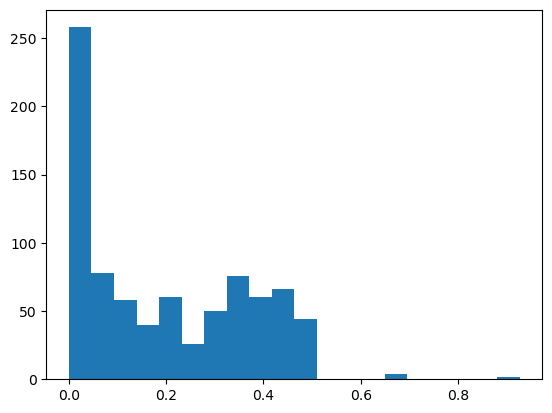

In [8]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage[adj_mat != 0], bins=20)


In [9]:
""" Find energy minima using simulated annealing, and see how often each edge is frustrated """

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, n_vars))
sa_minima, costs = simulated_annealing(initial_vectors, 100, 0.99, int(1e5), 
                              lambda vecs: hamiltonian_objective_function(vecs, adj_mat),
                              lambda vecs: flip_step_function(vecs, num_flips=1))


c:\Users\vicvi\BeliefNetworkEvo\CLEAN\notebooks\results\../../source_code\analyzers\optimization_analyzer.py:71: RuntimeWarning: overflow encountered in exp
  acceptance_prob_vector = np.where(new_cost_vector < old_cost_vector, 1, np.exp((old_cost_vector - new_cost_vector) / temperature))


In [10]:
""" calculate the frustration for the simulated annealing minima """

satisfaction_mats_sa = get_satisfaction_mats(adj_mat, sa_minima)
frust_percentage_sa = get_frust_percentage(satisfaction_mats_sa)

(array([280.,  80.,  64.,  40.,  54.,  44.,  74.,  68.,  38.,  30.,  46.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.     , 0.04635, 0.0927 , 0.13905, 0.1854 , 0.23175, 0.2781 ,
        0.32445, 0.3708 , 0.41715, 0.4635 , 0.50985, 0.5562 , 0.60255,
        0.6489 , 0.69525, 0.7416 , 0.78795, 0.8343 , 0.88065, 0.927  ]),
 <BarContainer object of 20 artists>)

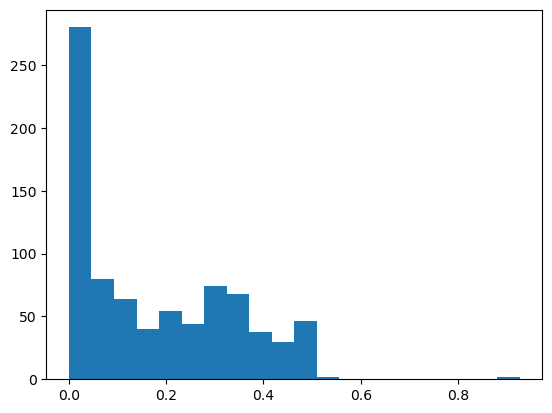

In [11]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage_sa[adj_mat != 0], bins=20)

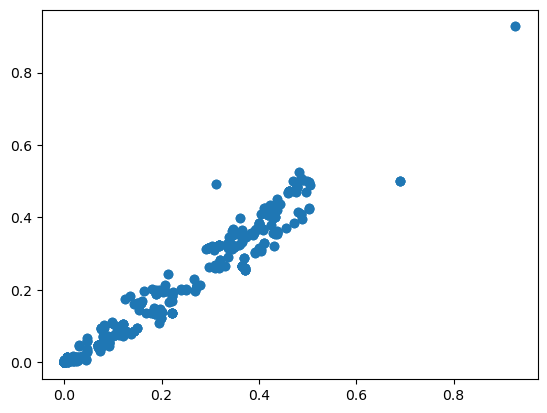

In [12]:
""" compare the minima with simulated annealing vs. multi-pass optimize """
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_sa[adj_mat != 0])

In [47]:
""" print the most frustrated edges """
sorted_indices = np.unravel_index(np.argsort(-frust_percentage, axis=None), frust_percentage.shape)

for i, j in zip(*sorted_indices):
    if i > j:
        print(f"{var_list[i]} -> {var_list[j]}")

RELIG_None -> RELIG_Catholic
WORKHARD -> THNKSELF
OBEY -> HELPOTH
RACDIF4 -> SPKMSLM
CONSCI -> PRAYER
FEFAM -> ABNOMORE
ABANY -> FEFAM
RACDIF4 -> TRUST
RACDIF4 -> HOMOSEX
LIBMSLM -> NATSPAC
LIBHOMO -> POLMURDR
POLHITOK -> SPKCOM
FEPOL -> SPKHOMO
COLHOMO -> FEFAM
SPKMSLM -> NATSPAC
CONBUS -> EQWLTH
LIBHOMO -> FEFAM
PRESLAST_DEMREP -> ABPOOR
PRESLAST_DEMREP -> ABNOMORE
PRESLAST_DEMREP -> ABANY
ABDEFECT -> POLVIEWS
SPKCOM -> TRUST
WOULDVOTELAST_NONCONFORM -> CONFED
PRAYER -> TRUST
CONARMY -> NATARMS
POLVIEWS -> ABNOMORE
ABANY -> POLVIEWS
ABPOOR -> POLVIEWS
ABSINGLE -> POLVIEWS
ABANY -> NATARMS
ABPOOR -> NATARMS
PREMARSX -> FEFAM
PRESLAST_DEMREP -> DIVLAW
PRESLAST_DEMREP -> GRASS
PRAYER -> WRKWAYUP
SPKCOM -> THNKSELF
SPKCOM -> OBEY
FEPOL -> HOMOSEX
FEPRESCH -> HOMOSEX
LIBMSLM -> TRUST
FEFAM -> HOMOSEX
ABSINGLE -> SPKMSLM
SPKMSLM -> ABANY
SPKMSLM -> ABNOMORE
OBEY -> LIBATH
OBEY -> ABANY
OBEY -> ABSINGLE
CONFINAN -> CONTV
OBEY -> SPKATH
HELPNOT -> CONFED
HELPNOT -> CONLABOR
PREMARSX -> POLVI

In [39]:
catholic_index = var_list.index("RELIG_Catholic")
christian_index = var_list.index("RELIG_Christian")
norel_index = var_list.index("RELIG_None")

frust_percentage[norel_index, catholic_index]

np.float64(0.927)

In [43]:
conmedic_index = var_list.index("CONMEDIC")
xmarsex_index = var_list.index("SPKMSLM")

frust_percentage[conmedic_index, xmarsex_index]

np.float64(0.0)

In [45]:
""" print the most frustrated edges for simulated annealing """
sorted_indices_sa = np.unravel_index(np.argsort(-frust_percentage_sa, axis=None), frust_percentage_sa.shape)

for i, j in zip(*sorted_indices_sa):
    print(f"{var_list[i]} -> {var_list[j]}")

RELIG_None -> RELIG_Catholic
RELIG_Catholic -> RELIG_None
EQWLTH -> CONBUS
CONBUS -> EQWLTH
SPKMSLM -> NATSPAC
NATSPAC -> SPKMSLM
POLHITOK -> SPKCOM
LIBMSLM -> NATSPAC
NATSPAC -> LIBMSLM
SPKCOM -> POLHITOK
NATARMS -> CONARMY
THNKSELF -> WORKHARD
OBEY -> HELPOTH
HELPOTH -> OBEY
CONARMY -> NATARMS
WORKHARD -> THNKSELF
TRUST -> RACDIF4
RACDIF4 -> TRUST
CONSCI -> PRAYER
PRAYER -> CONSCI
THNKSELF -> HELPOTH
HELPOTH -> THNKSELF
RACDIF4 -> SPKMSLM
SPKMSLM -> RACDIF4
PRESLAST_DEMREP -> ABPOOR
ABPOOR -> PRESLAST_DEMREP
ABNOMORE -> PRESLAST_DEMREP
ABANY -> PRESLAST_DEMREP
PRESLAST_DEMREP -> ABANY
PRESLAST_DEMREP -> ABNOMORE
ABDEFECT -> POLVIEWS
POLVIEWS -> ABDEFECT
ABPOOR -> POLVIEWS
POLVIEWS -> ABSINGLE
POLVIEWS -> ABPOOR
PRAYER -> TRUST
TRUST -> PRAYER
ABSINGLE -> POLVIEWS
ABNOMORE -> POLVIEWS
ABANY -> POLVIEWS
POLVIEWS -> ABNOMORE
POLVIEWS -> ABANY
RACDIF4 -> HOMOSEX
HOMOSEX -> RACDIF4
SPKCOM -> TRUST
TRUST -> SPKCOM
NATARMS -> ABPOOR
ABPOOR -> NATARMS
ABANY -> NATARMS
NATARMS -> ABANY
LIBMSL

In [15]:
""" get a set of vector assignments by doing breadth first search on the graph"""

bfs_vectors = np.zeros((1000, adj_mat.shape[0]))
for i in range(1000):
    assignments = assign_nodes_search(G, breadth_first=True)
    
    for j, node in enumerate(var_list):
        bfs_vectors[i, j] = assignments[node][0]  

(array([634., 126.,  14.,   4.,   8.,   2.,   6.,   2.,   0.,   0.,   2.,
          2.,   0.,   2.,   6.,   2.,   8.,   2.,   0.,   2.]),
 array([0.    , 0.0394, 0.0788, 0.1182, 0.1576, 0.197 , 0.2364, 0.2758,
        0.3152, 0.3546, 0.394 , 0.4334, 0.4728, 0.5122, 0.5516, 0.591 ,
        0.6304, 0.6698, 0.7092, 0.7486, 0.788 ]),
 <BarContainer object of 20 artists>)

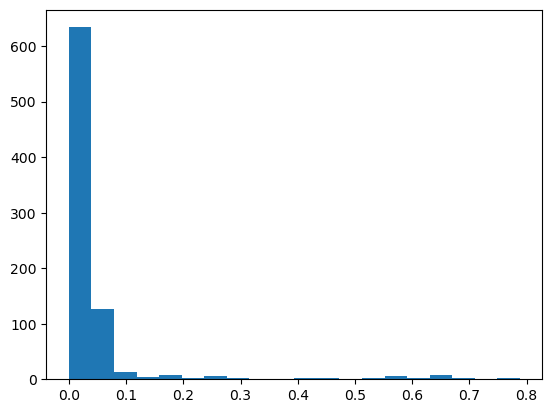

In [16]:
""" make a histogram of the frustrations for breadth first search """

satisfaction_mats_bfs = get_satisfaction_mats(adj_mat, bfs_vectors)
frust_percentage_bfs = get_frust_percentage(satisfaction_mats_bfs)

plt.hist(frust_percentage_bfs[adj_mat != 0], bins=20)

In [17]:
"""
make the networkx graph of the adjacency matrix, because thisis how I implemented the breadth first search
"""

'\nmake the networkx graph of the adjacency matrix, because thisis how I implemented the breadth first search\n'

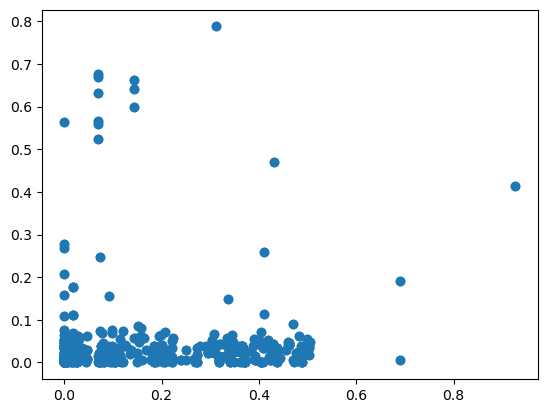

In [18]:
""" see if bfs frustration is related to the one we get from the optimization functions """

plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_bfs[adj_mat != 0])

In [19]:
""" get a set of vector assignments by doing a random walk on the graph"""

rw_vectors = np.zeros((1000, adj_mat.shape[0]))
for i in range(100):
    assignments = assign_nodes_random_walk(G, weighted=True, iterations_per_node=100)
    
    for j, node in enumerate(var_list):
        rw_vectors[i, j] = assignments[node] 

(array([680.,  36.,  62.,   4.,  14.,   6.,   2.,   0.,   4.,   2.,   0.,
          4.,   2.,   2.,   0.,   0.,   2.,   0.,   0.,   2.]),
 array([0.    , 0.0045, 0.009 , 0.0135, 0.018 , 0.0225, 0.027 , 0.0315,
        0.036 , 0.0405, 0.045 , 0.0495, 0.054 , 0.0585, 0.063 , 0.0675,
        0.072 , 0.0765, 0.081 , 0.0855, 0.09  ]),
 <BarContainer object of 20 artists>)

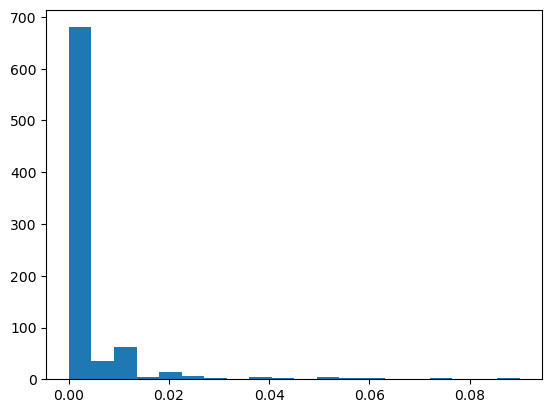

In [20]:
""" make a histogram of the frustrations """

frust_mat_rw = get_satisfaction_mats(adj_mat, rw_vectors)
frust_percentage_rw = get_frust_percentage(frust_mat_rw)

plt.hist(frust_percentage_rw[adj_mat != 0], bins=20)

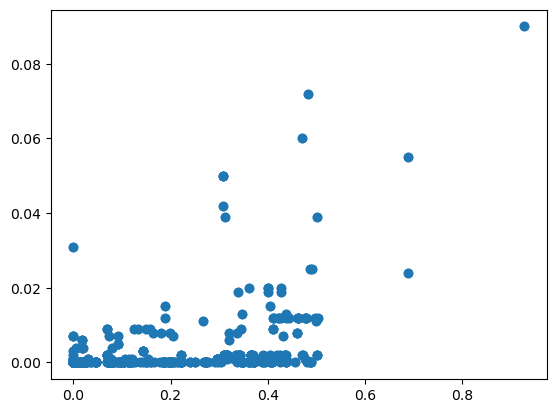

In [21]:
""" are the random walk frustrations related to the optimization frustrations?
    yes, in some way, it seems that the ones with high frustration in the optimization have potential to be more frustrated 
    in the random walk, but they can also be unfrustrated.
"""
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_rw[adj_mat != 0])

[np.float64(6.646760619546298e-05), np.float64(0.0024259206882272853), np.float64(0.005383854822423798), np.float64(0.009225354124104712), np.float64(0.011719242710228535), np.float64(0.013681486217068847), np.float64(0.016268722067371268), np.float64(0.019632631596324595), np.float64(0.02564010225355024), np.float64(0.02933576953734134), np.float64(0.036085710272920755), np.float64(0.04424404862225893), np.float64(0.05051997746609877), np.float64(0.06107469934921865), np.float64(0.07218926793506793), np.float64(0.09018977908759224), np.float64(0.11174335415965551), np.float64(0.1264473635881056), np.float64(0.14812246266887494), np.float64(0.18971459986776054), np.float64(0.26825240766022046)]


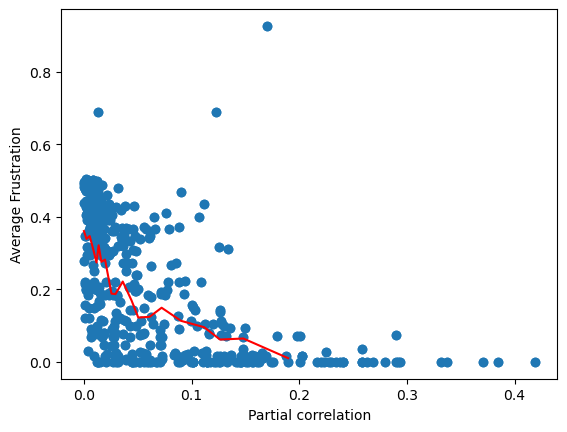

In [22]:
""" plot frustration as it relates to the strength of the partial correlation """
plt.scatter(np.abs(adj_mat[adj_mat != 0]), frust_percentage[adj_mat != 0])

""" plot the average frustration for each window of correlation values """
# Calculate the absolute values of the non-zero correlations
abs_correlations = np.abs(adj_mat[adj_mat != 0])

# Sort the absolute correlations
sorted_correlations = np.sort(abs_correlations)

# Determine the bin edges such that each bin has 50 entries
bin_edges = [sorted_correlations[i] for i in range(0, len(sorted_correlations), 40)]
print(bin_edges)

bin_edges[-1] = sorted_correlations[-1] # Ensure the last edge includes the maximum value

# Calculate the average frustration for each bin
bin_means = []

for i in range(len(bin_edges) - 1):
    bin_mask = (abs_correlations >= bin_edges[i]) & (abs_correlations < bin_edges[i + 1])
    bin_means.append(frust_percentage[adj_mat != 0][bin_mask].mean())

# Plot the average frustration for each bin
plt.plot(bin_edges[:-1], bin_means, color="r")
plt.xlabel('Partial correlation')
plt.ylabel('Average Frustration')
plt.show()

[np.float64(0.17766446468645042), np.float64(0.21381194848962495), np.float64(0.22672712932862538), np.float64(0.23746538265248868), np.float64(0.2472723462349699), np.float64(0.25296915053902375), np.float64(0.26018340309723365), np.float64(0.26981569851192017), np.float64(0.27621316068727575), np.float64(0.2874448519381415), np.float64(0.30047074385825645), np.float64(0.3137227704777668), np.float64(0.3256281475204985), np.float64(0.34871128669812856), np.float64(0.3628238241613495), np.float64(0.38326373670116765), np.float64(0.4143362315553424), np.float64(0.4561644569019244), np.float64(0.4828711904013143), np.float64(0.5182836842943257), np.float64(0.6427246444120968)]


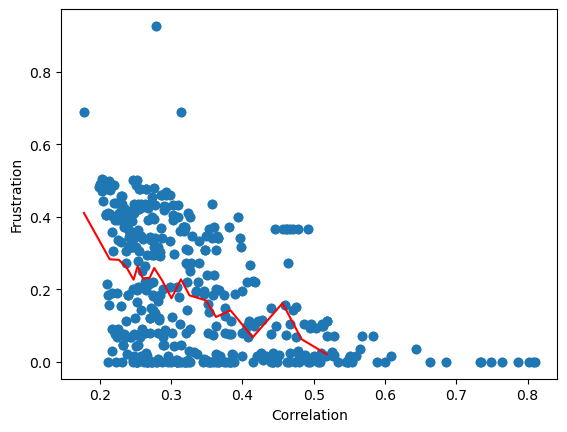

In [23]:
""" plot frustration as it relates to the strength of the partial correlation """
plt.scatter(np.abs(corr_matrix[adj_mat != 0]), frust_percentage[adj_mat != 0])

""" plot the average frustration for each window of correlation values """
# Calculate the absolute values of the non-zero correlations
abs_correlations = np.abs(corr_matrix[adj_mat != 0])

# Sort the absolute correlations
sorted_correlations = np.sort(abs_correlations)

# Determine the bin edges such that each bin has 50 entries
bin_edges = [sorted_correlations[i] for i in range(0, len(sorted_correlations), 40)]
print(bin_edges)

bin_edges[-1] = sorted_correlations[-1] # Ensure the last edge includes the maximum value

# Calculate the average frustration for each bin
bin_means = []

for i in range(len(bin_edges) - 1):
    bin_mask = (abs_correlations >= bin_edges[i]) & (abs_correlations < bin_edges[i + 1])
    bin_means.append(frust_percentage[adj_mat != 0][bin_mask].mean())

# Plot the average frustration for each bin
plt.plot(bin_edges[:-1], bin_means, color="r")
plt.xlabel('Correlation')
plt.ylabel('Frustration')
plt.show()

In [34]:
# display the graph to make sure this works
net = display_graph_pyvis(partial_corr_matrix, edge_type_matrix=frust_percentage, rank_edge_coloring=True)
net.show(f"visual.html")

number of edges 411
visual.html


In [24]:
""" TODO move this testing stuff to a proper file """
test_adj_mat = np.array([[1, 2, 3],
                         [4, 5, 6],
                         [7, 8, 9]])

test_vectors = np.array([[-1,  1, -1],
                         [ 1, -1,  1],
                         [-1, -1,  1],
                         [ 1, -1, -1],
                         [-1, -1, -1]])

expected_quad_form = np.array([[[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1,  2, -3],[4, 5, -6],[-7, -8, 9]],
                               [[1, -2, -3],[-4, 5, 6],[-7, 8, 9]],
                               [[1, 2, 3],[4, 5, 6], [7, 8, 9]]])

np.testing.assert_array_equal(expected_quad_form, get_frust_mat(test_adj_mat, test_vectors))

NameError: name 'get_frust_mat' is not defined

: 

: 